# Generating tables and plots for the paper

The code in this notebook generates Tables 4 and 5, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

Note: The latest version of this notebook is maintained at the repo [trungdong/provenance-kernel-evaluation](https://github.com/trungdong/provenance-kernel-evaluation) on Github.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
from scripts.experiments.common import method_short_names

## Loading scoring and timing data

In [3]:
OUTPUTS_PATH = Path("outputs/")

In [4]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = OUTPUTS_PATH / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [5]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [6]:
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]

In [7]:
# The following graph kernels are in the "slow" group
slow_GKs = {
    "GK-GSamp",
    "GK-NSPD",
    "GK-NH",
    "GK-SPath",
    "GK-WL-OA-1",
    "GK-WL-OA-2",
    "GK-WL-OA-3",
    "GK-WL-OA-4",
    "GK-WL-OA-5",
    "GK-OddSth",
}

group_prefixes = {
    "GK": "GK-fast",  # all other graph kernels are in the "fast" group
    "PNA": "PNA",  # Provenance Network Analytics method
    "FG": "PK-G",  # provenance kernels using generic PROV types
    "FA": "PK-A",  # provenance kernels using generic PROV types and application types
    "DG": "PK-GD",  # provenance kernels using generic PROV types with 2-length derivations
    "DA": "PK-AD",  # provenance kernels using generic PROV types and application types with 2-length derivations
    "TG": "PK-GT",  # kernels with WdfT transformations (generic PROV types)
    "TA": "PK-AT",  # kernels with WdfT transformations (generic PROV types + application types)
}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    try:
        prefix = method.split("-", 1)[0]
        return group_prefixes[prefix]
    except KeyError:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = set()
    for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]:
        group_scorings = results[results.group_name == group_name]
        if group_scorings.empty:
            continue
        best_methods.add(group_scorings.groupby("method")[scoring].mean().idxmax())

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]


### Loading scoring of the best methods

In [8]:
scorings_to_plots = []

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings_to_plots.append(best_performers(df))

scorings = pd.concat(scorings_to_plots, ignore_index=True)

## Comparing timings of the best methods in each classification task

In [9]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary

accuracy        f1    recall  precision   
dataset group_name method                                                
CM-B    GK-fast    GK-HC-3     0.896719  0.896719  0.896719   0.896719  \
        GK-slow    GK-WL-OA-4  0.902055  0.902055  0.902055   0.902055   
        PK-A       FA-0        0.899422  0.899422  0.899422   0.899422   
        PK-G       FG-2        0.898325  0.898325  0.898325   0.898325   
        PNA        PNA-RF      0.894161  0.894161  0.894161   0.894161   
CM-R    GK-fast    GK-WL-2     0.978327  0.978327  0.978327   0.978327   
        GK-slow    GK-WL-OA-5  0.970567  0.970567  0.970567   0.970567   
        PK-A       FA-5        0.969742  0.969742  0.969742   0.969742   
        PK-G       FG-4        0.925892  0.925892  0.925892   0.925892   
        PNA        PNA-DTree   0.934621  0.934621  0.934621   0.934621   
CM-RS   GK-fast    GK-WL-4     0.950266  0.950266  0.950266   0.950266   
        GK-slow    GK-WL-OA-5  0.960997  0.960997  0.960997   0.960997   
        PK-A       FA-3        0.966883  0.966883  0.966883   0.966883   
        PK-G       FG-5        0.956799  0.956799  0.956799   0.956799   
        PNA        PNA-DTree   0.940655  0.940655  0.940655   0.940655   
MIMIC   GK-fast    GK-WL-2     0.797096  0.797096  0.797096   0.797096   
        GK-slow    GK-GSamp    0.806343  0.806343  0.806343   0.806343   
        PK-A       FA-0        0.792040  0.792040  0.792040   0.792040   
        PK-G       FG-5        0.759197  0.759197  0.759197   0.759197   
        PNA        PNA-SVM     0.750739  0.750739  0.750739   0.750739   
PG-D    GK-fast    GK-WL-5     0.754833  0.754833  0.754833   0.754833   
        GK-slow    GK-SPath    0.775333  0.775333  0.775333   0.775333   
        PK-A       FA-2        0.782917  0.782917  0.782917   0.782917   
        PK-G       FG-5        0.752083  0.752083  0.752083   0.752083   
        PNA        PNA-SVM     0.712583  0.712583  0.712583   0.712583   
PG-T    GK-fast    GK-WL-5     0.705167  0.705167  0.705167   0.705167   
        GK-slow    GK-OddSth   0.719250  0.719250  0.719250   0.719250   
        PK-A       FA-3        0.853083  0.853083  0.853083   0.853083   
        PK-G       FG-3        0.691500  0.691500  0.691500   0.691500   
        PNA        PNA-DTree   0.694333  0.694333  0.694333   0.694333   

                                     time  
dataset group_name method                  
CM-B    GK-fast    GK-HC-3       0.529593  
        GK-slow    GK-WL-OA-4   15.614797  
        PK-A       FA-0          0.259039  
        PK-G       FG-2          0.434829  
        PNA        PNA-RF       41.379174  
CM-R    GK-fast    GK-WL-2       1.219007  
        GK-slow    GK-WL-OA-5   47.064925  
        PK-A       FA-5          1.261810  
        PK-G       FG-4          1.174168  
        PNA        PNA-DTree   116.377211  
CM-RS   GK-fast    GK-WL-4       3.908286  
        GK-slow    GK-WL-OA-5  127.468742  
        PK-A       FA-3          2.219201  
        PK-G       FG-5          2.080615  
        PNA        PNA-DTree   230.907614  
MIMIC   GK-fast    GK-WL-2       5.955811  
        GK-slow    GK-GSamp    714.984181  
        PK-A       FA-0          2.938546  
        PK-G       FG-5         12.691655  
        PNA        PNA-SVM     823.799291  
PG-D    GK-fast    GK-WL-5       1.586696  
        GK-slow    GK-SPath      6.730149  
        PK-A       FA-2          1.653015  
        PK-G       FG-5          2.664313  
        PNA        PNA-SVM     273.788813  
PG-T    GK-fast    GK-WL-5       0.675800  
        GK-slow    GK-OddSth     4.304139  
        PK-A       FA-3          0.901460  
        PK-G       FG-3          0.589314  
        PNA        PNA-DTree    72.054262

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [10]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
best_pk_method = dict()  # achieved by which method
best_pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = True
        try:
            if best_pk_accuracy[dataset] > row.accuracy:
                to_be_updated = False
        except KeyError:
            pass  # first time seeing this dataset, to reco

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            best_pk_method[dataset] = method
            best_pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [11]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / best_pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [12]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [13]:
table4 = rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]
table4

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,4.3 (G5),1.0 (A0),2.0 (WL2),243.3 (GS),280.3 (SVM)
CM-B,1.7 (G2),1.0 (A0),2.0 (HC3),60.3 (WLO4),159.7 (RF)
CM-R,0.9 (G4),1.0 (A5),1.0 (WL2),37.3 (WLO5),92.2 (DT)
CM-RS,0.9 (G5),1.0 (A3),1.8 (WL4),57.4 (WLO5),104.0 (DT)
PG-T,0.7 (G3),1.0 (A3),0.7 (WL5),4.8 (ODD),79.9 (DT)
PG-D,1.6 (G5),1.0 (A2),1.0 (WL5),4.1 (SP),165.6 (SVM)


In [14]:
# Save table 4 for later
table4.to_csv("plots/table4.csv")
table4.to_html("plots/table4.html")

## Comparing the accuracy of the best PK method vs the best in the other comparison groups

In [15]:
def ranksums(df: pd.DataFrame, methods, scoring="accuracy", pvalue_significant=0.05):
    # returns None if the difference between the two methods is not statistically significant
    # according to the ranksums test; otherwise, returns the mean difference value.

    assert len(methods) == 2
    assert scoring in df.columns

    print("Wilcoxon rank-sum test:", scoring)
    print(f"> Comparing {methods[0]} vs {methods[1]}")

    p1 = df[df.method == methods[0]]
    p1.reset_index(inplace=True)
    p1_mean = p1[scoring].mean()

    p2 = df[df.method == methods[1]]
    p2.reset_index(inplace=True)
    p2_mean = p2[scoring].mean()

    mean_diff = p1_mean - p2_mean
    _, pvalue = stats.ranksums(p1[scoring], p2[scoring])
    if pvalue > pvalue_significant:
        print(f"> Insignificant (pvalue = {pvalue * 100:.1f}%)")
        return None
    else:
        print(f"> *Significant* (pvalue = {pvalue * 100:.1f}%)")
        print(f"> Mean difference: {mean_diff * 100:+.1f}%")
        return mean_diff

In [16]:
def mean_diff_value_display(mean_diff, min_diff=0.02):
    if mean_diff is None:
        return "="

    # mean_diff is not None
    if abs(mean_diff) >= min_diff:
        return f"{mean_diff * 100:.0f}%"
    else:
        return "="

### Table 5

Summary of the accuracy differences between the best-performing PK-based method and the best-performing method in the GK-slow, GK-fast, and PNA groups. An “=” sign means the accuracy difference is not statistically significant according to the Wilcoxson Rank Sum test (also known as Mann Whitney U Test); while a positive/negative value shows how much the PK-based method outperforms/under-performs the corresponding GK/PNA method, respectively, when the difference is statistically significant.

In [17]:
def rank_against(selected_groups, scoring="accuracy", min_diff=0.02):
    # Looking for the best method in the select groups for each dataset
    # calculate their mean scoring
    df = scorings[scorings.group_name.isin(selected_groups)].groupby(["dataset", "method"]).mean(numeric_only=True)
    # find the method with the highest mean scoring value for each dataset
    best_method = {
        dataset: group.set_index("method")[scoring].idxmax()
        for dataset, group in df.reset_index().groupby("dataset")
    }

    data = []
    for row in summary.itertuples():
        dataset, group_name, method = row.Index
        if method != best_method[dataset]:
            print(f"[ {dataset}: comparing {best_method[dataset]} against {method} ]")
            mean_diff = ranksums(scorings[scorings.dataset == dataset], [best_method[dataset], method])
            # ignoring difference less than min_diff
            cell_value = mean_diff_value_display(mean_diff, min_diff)
        else:
            cell_value = f"[{method_short_names.get(method, method)}]"
        data.append((dataset, group_name, method, cell_value))

    comp_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Diff"])
    return comp_df

In [18]:
comparison_df = rank_against({"PK-A", "PK-D"}, min_diff=0.02)

[ CM-B: comparing FA-0 against GK-HC-3 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs GK-HC-3
> Insignificant (pvalue = 38.6%)
[ CM-B: comparing FA-0 against GK-WL-OA-4 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs GK-WL-OA-4
> Insignificant (pvalue = 35.7%)
[ CM-B: comparing FA-0 against FG-2 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs FG-2
> Insignificant (pvalue = 66.5%)
[ CM-B: comparing FA-0 against PNA-RF ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs PNA-RF
> Insignificant (pvalue = 8.9%)
[ CM-R: comparing FA-5 against GK-WL-2 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-2
> *Significant* (pvalue = 0.0%)
> Mean difference: -0.9%
[ CM-R: comparing FA-5 against GK-WL-OA-5 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-OA-5
> Insignificant (pvalue = 91.2%)
[ CM-R: comparing FA-5 against FG-4 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs FG-4
> *Significant* (pvalue = 0.0%)
> Mean difference: +4.4%
[ CM-R: co

In [19]:
table5 = comparison_df.pivot(index="Group", columns="Dataset", values="Diff").reindex(["GK-slow", "GK-fast", "PNA"])[dataset_names]
table5

Dataset,MIMIC,CM-B,CM-R,CM-RS,PG-T,PG-D
Group,,,,,,
GK-slow,=,=,=,=,13%,=
GK-fast,=,=,=,=,15%,3%
PNA,4%,=,4%,3%,16%,7%


In [20]:
# Save Table 5 for later
table5.to_csv("plots/table5.csv")
table5.to_html("plots/table5.html")

## Generating plots

In [21]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

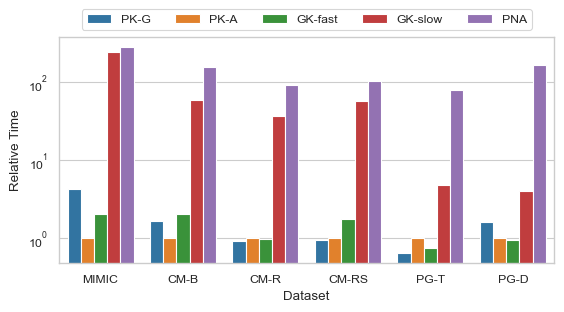

In [22]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [23]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

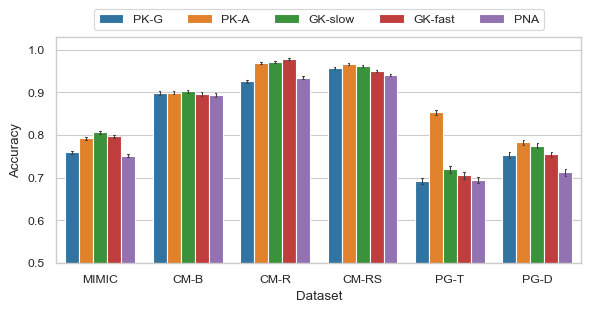

In [24]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.ylim(0.5)
plt.tight_layout()

In [25]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")

## Extra plots and information

### Time complexity of generating provenance types

600 random provenance graphs are generated by [ProvToolbox](http://lucmoreau.github.io/ProvToolbox/) (option `--generator`) with the following parameters:
- Number of nodes $N$: 10, 100, 1K, 10K, 100K, 1M;
- Max number of branches $n$ (edges branching out from a node): 1, 2, 4, 8, 16; and
- Randon seed in $[1..20]$.
So, for each value of $N$, there are 100 graphs, out of which each value of $n$ has 20 graphs.

The provenance types level-$h$ of the above graphs are generated and the duration measured in seconds, with $h \in [0, 5]$.

Below, we plot the time cost against the number of nodes $N$ and against the level $h$.

In [26]:
timings_df = pd.read_pickle(OUTPUTS_PATH / "timings_for_gen_graphs.pickled")

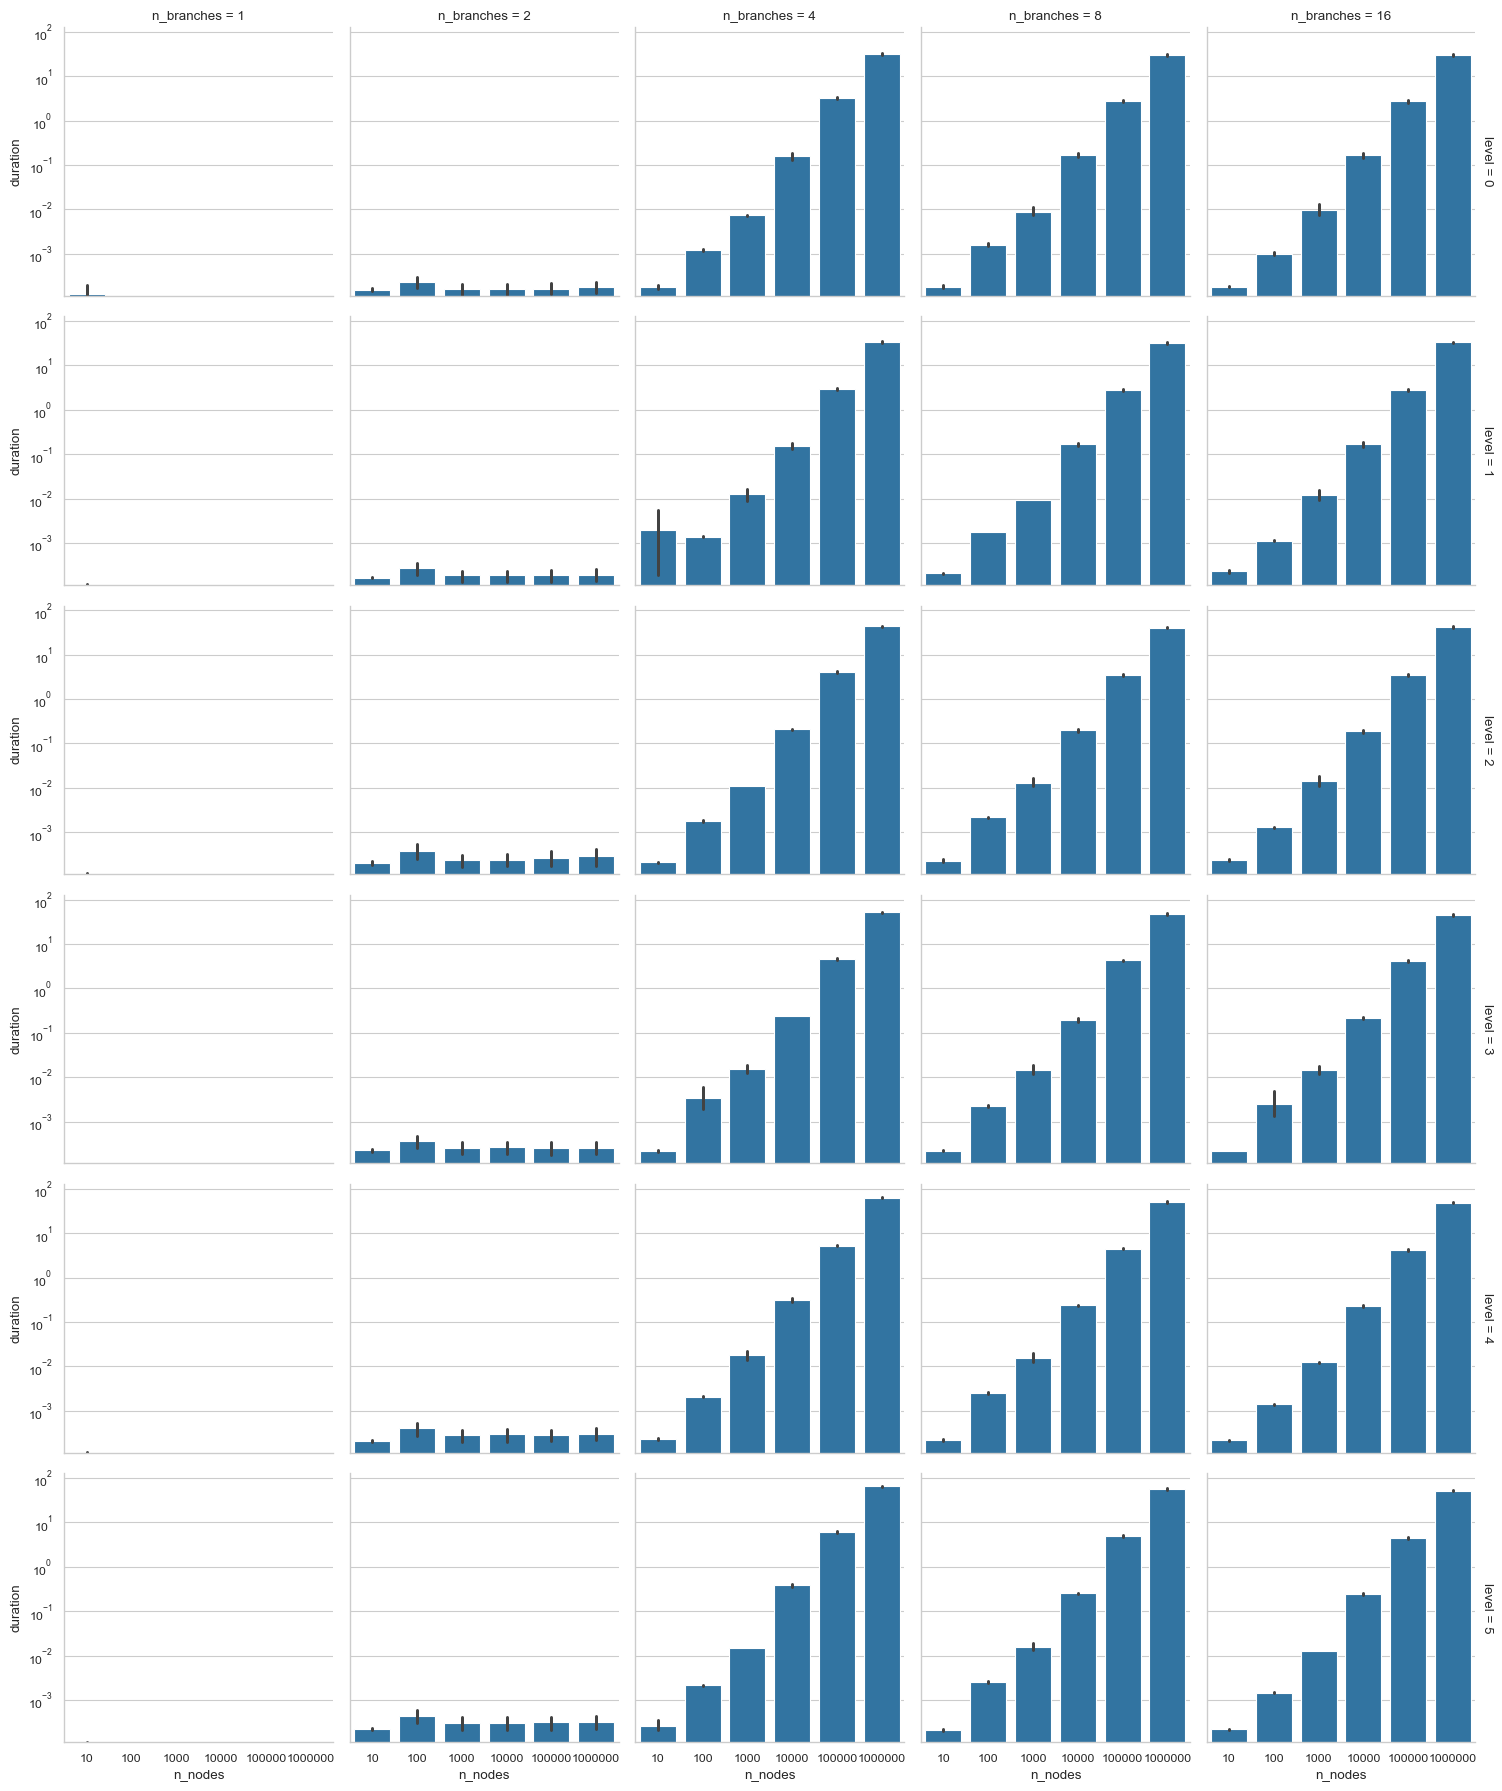

In [27]:
g = sns.FacetGrid(timings_df, col="n_branches", row="level", margin_titles=True)
plot = g.map(sns.barplot, "n_nodes", "duration", order=[10, 100, 1000, 10000, 100000, 1000000]).set(yscale="log")

In [28]:
plot.figure.savefig("plots/pk-time-cost-grid-by-size.pdf")
plot.figure.savefig("plots/pk-time-cost-grid-by-size.png")

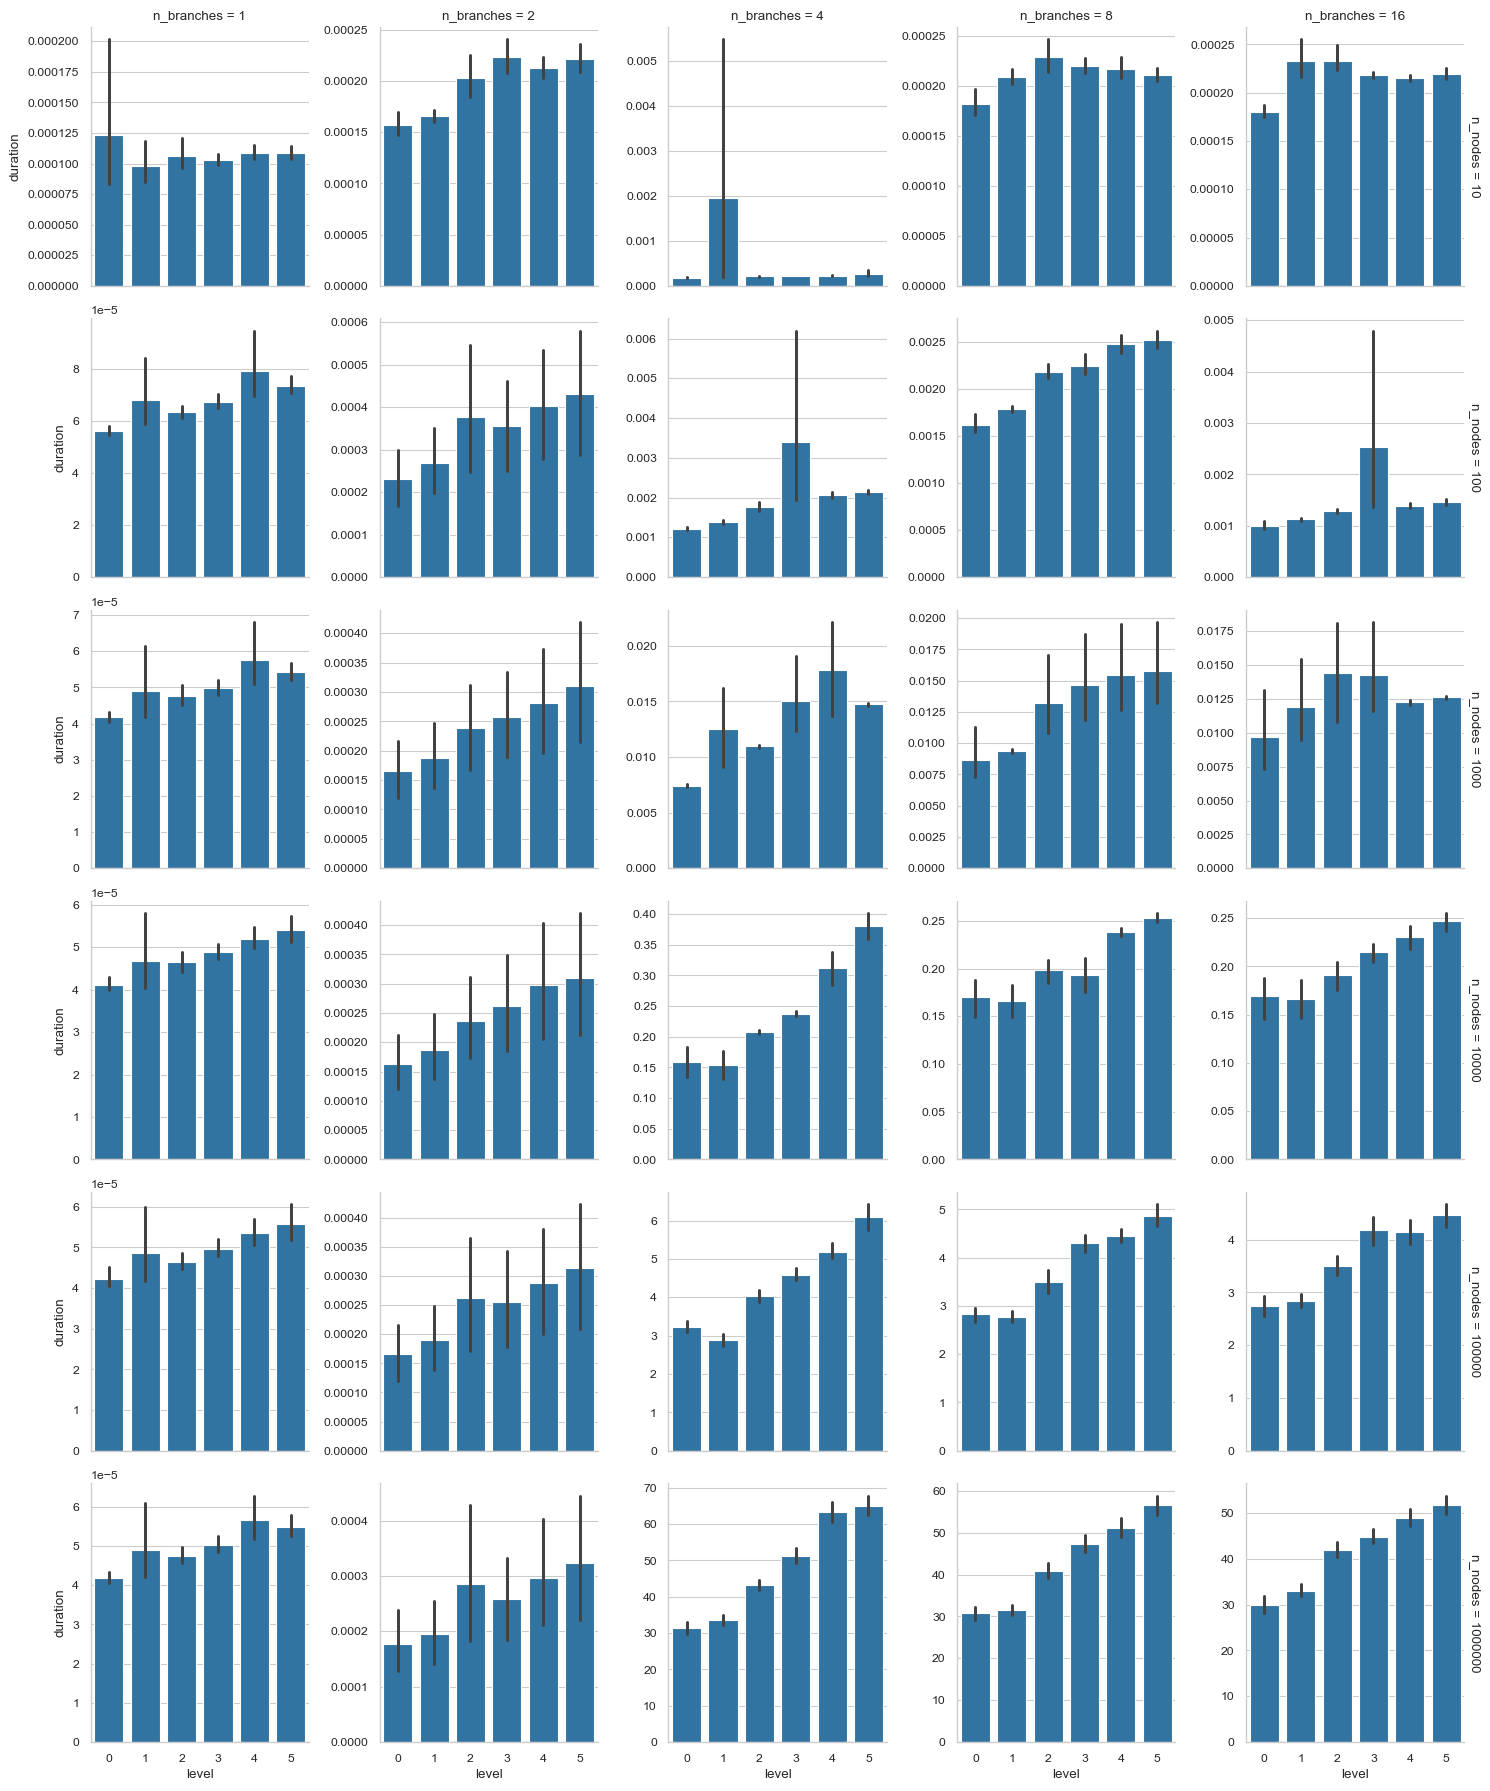

In [29]:
g = sns.FacetGrid(timings_df, col="n_branches", row="n_nodes", sharey=False, margin_titles=True)
plot = g.map(sns.barplot, "level", "duration", order=[0, 1, 2, 3, 4, 5])

In [30]:
plot.figure.savefig("plots/pk-time-cost-grid-by-level.pdf")
plot.figure.savefig("plots/pk-time-cost-grid-by-level.png")

### Parameters used to set up ML algorithms

The following off-the-shelf ML classifiers provided by the [Scikit-learn library](https://scikit-learn.org/) were employed to classify provenance graphs based on their provenance network metrics.
- [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (DT)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (RF)
- [K-Neighbour](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) (KN)
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) (NB)
- [Multi-layer Perceptron neural network](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) (NN)
- [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (SVM). In this case, we followed the library's advice to scale the input data with a [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Here we provided the parameters that were used to set up each of the algorithms.

In [31]:
import json
from scripts.experiments.common import ML_CLASSIFIERS

In [32]:
class PermissiveJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        try: 
            return json.JSONEncoder.default(self, obj)
        except TypeError:
            return repr(obj)

In [33]:
for clf_name, clf in ML_CLASSIFIERS.items():
    print(f"---- Parameters for {clf_name} ----")
    print(json.dumps(clf.get_params(), indent=2, cls=PermissiveJSONEncoder))

---- Parameters for DTree ----
{
  "ccp_alpha": 0.0,
  "class_weight": null,
  "criterion": "gini",
  "max_depth": 5,
  "max_features": null,
  "max_leaf_nodes": null,
  "min_impurity_decrease": 0.0,
  "min_samples_leaf": 1,
  "min_samples_split": 2,
  "min_weight_fraction_leaf": 0.0,
  "random_state": null,
  "splitter": "best"
}
---- Parameters for RF ----
{
  "bootstrap": true,
  "ccp_alpha": 0.0,
  "class_weight": null,
  "criterion": "gini",
  "max_depth": 5,
  "max_features": "sqrt",
  "max_leaf_nodes": null,
  "max_samples": null,
  "min_impurity_decrease": 0.0,
  "min_samples_leaf": 1,
  "min_samples_split": 2,
  "min_weight_fraction_leaf": 0.0,
  "n_estimators": 10,
  "n_jobs": null,
  "oob_score": false,
  "random_state": null,
  "verbose": 0,
  "warm_start": false
}
---- Parameters for K-NB ----
{
  "algorithm": "auto",
  "leaf_size": 30,
  "metric": "minkowski",
  "metric_params": null,
  "n_jobs": null,
  "n_neighbors": 8,
  "p": 2,
  "weights": "uniform"
}
---- Parameters